# Velocity at Depth Levels

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of Eulerian velocity fields at depth levels;

In [1]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools import m6toolbox
import matplotlib.pyplot as plt
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import yaml, intake
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

# load avg dates
avg = diag_config_yml['Avg']

# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
DOUT_S = dcase.get_value('DOUT_S')
if DOUT_S:
  OUTDIR = dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = dcase.get_value('RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', dcase.casename)

Output directory is: /glade/scratch/gmarques/archive/g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001/ocn/hist/
Casename is: g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001


In [3]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass# create an empty class object
class args:
  pass

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = dcase.casename
args.monthly = dcase.casename+diag_config_yml['Fnames']['z']
args.static = dcase.casename+diag_config_yml['Fnames']['static']
args.savefigs = False
args.nw = 6 

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = dcase.casename
args.monthly = dcase.casename+diag_config_yml['Fnames']['z']
args.static = dcase.casename+diag_config_yml['Fnames']['static']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [4]:
# Parameters
sname = "placeholder-sname"
subset_kwargs = {}
product = "/glade/u/home/eromashkova/codes/mom6-tools/docs/source/examples/computed_notebooks/placeholder-sname/velocity_levels.ipynb"


In [5]:
# load mom6 grid
grd = MOM6grid(OUTDIR+args.static)

MOM6 grid successfully loaded... 



In [6]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)

In [7]:
client

<Client: 'tcp://10.12.206.57:35269' processes=0 threads=0, memory=0 B>

In [8]:
# load history files

def preprocess(ds):
    ''' Return a dataset desired variables'''
    variables = ['uo', 'vo', 'time', 'time_bounds']
    return ds[variables]

ds = xr.open_mfdataset(OUTDIR+args.monthly, \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [9]:
# Select data
%time 
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [10]:
# compute annual mean and then average in time
ds_ann = m6toolbox.weighted_temporal_mean_vars(ds_sel)
uo = np.ma.masked_invalid(ds_ann.uo.mean('time').values)
vo = np.ma.masked_invalid(ds_ann.vo.mean('time').values)

### Zonal velocity

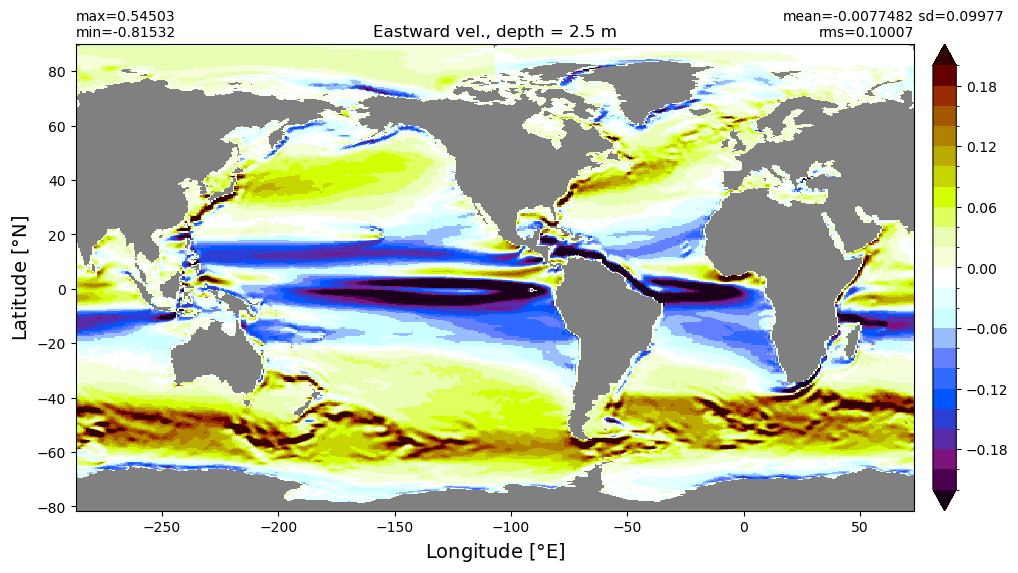

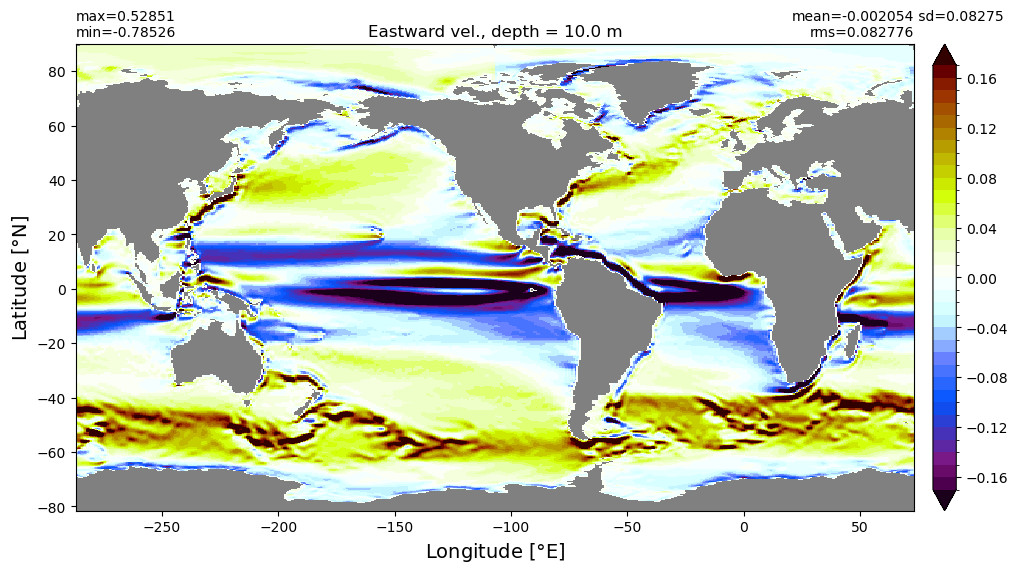

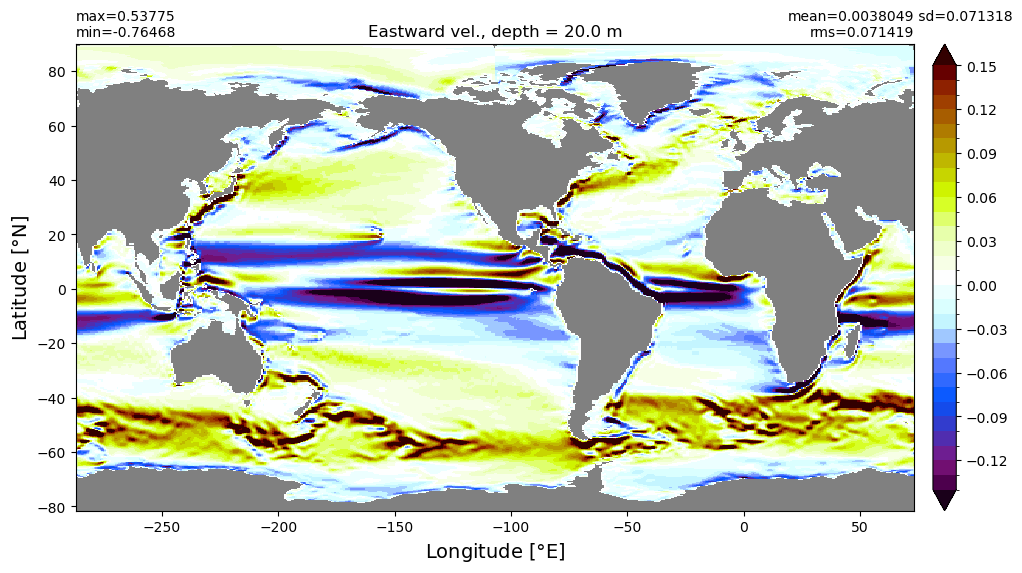

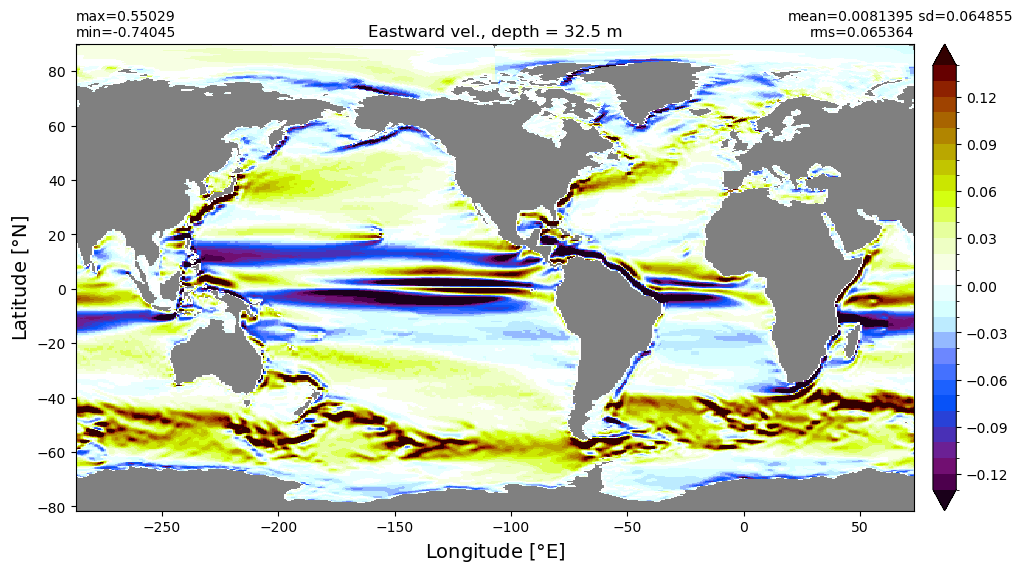

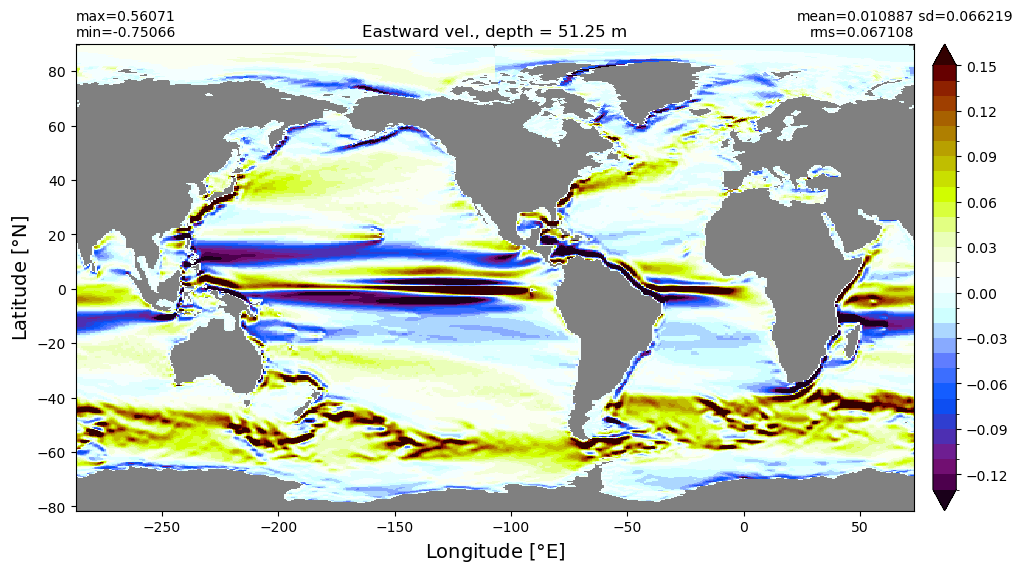

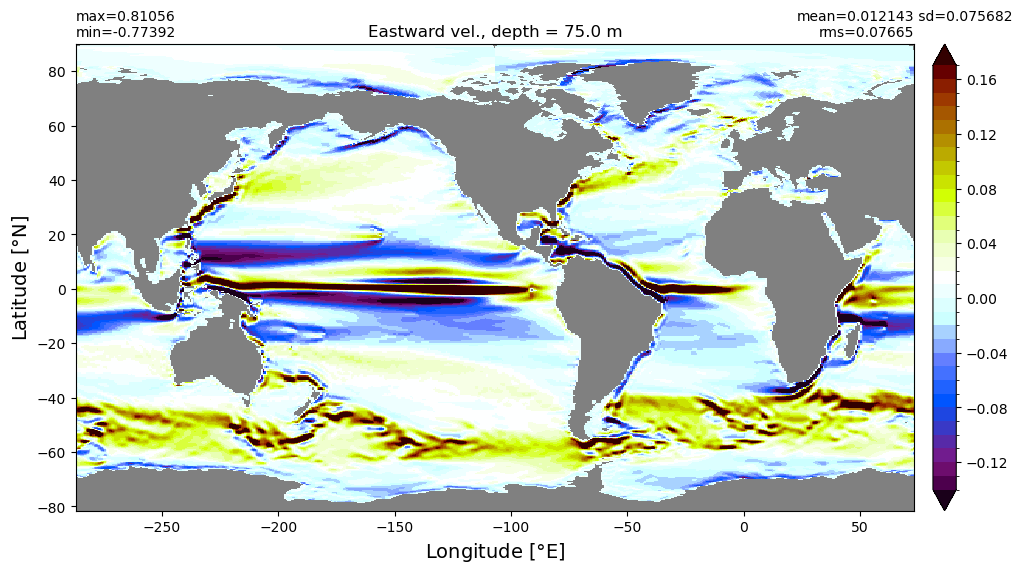

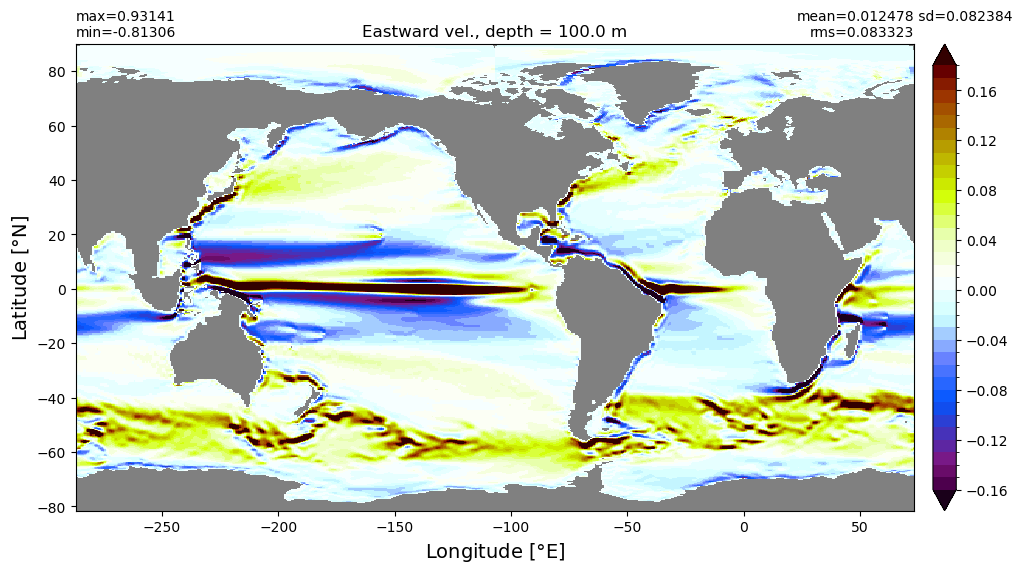

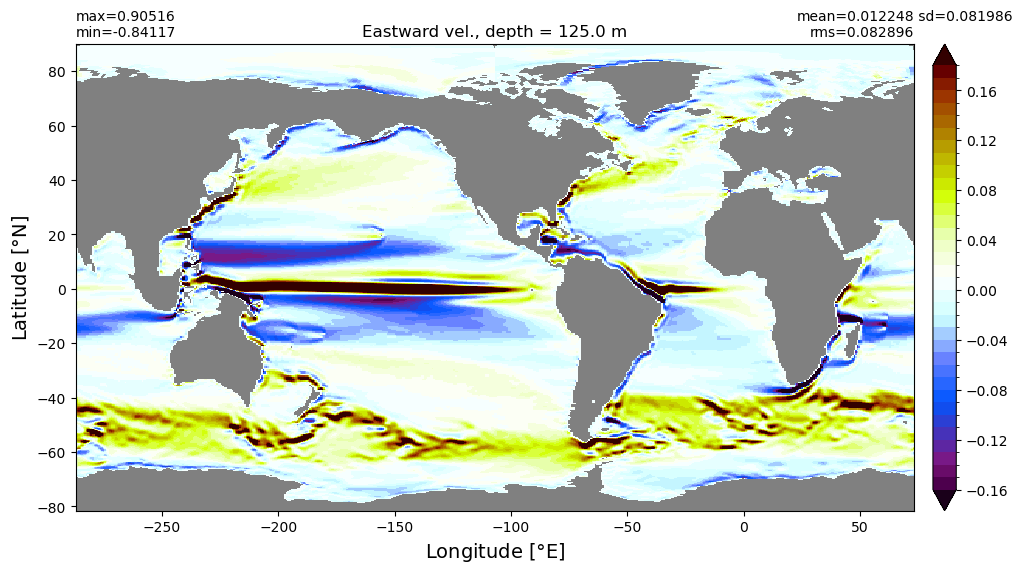

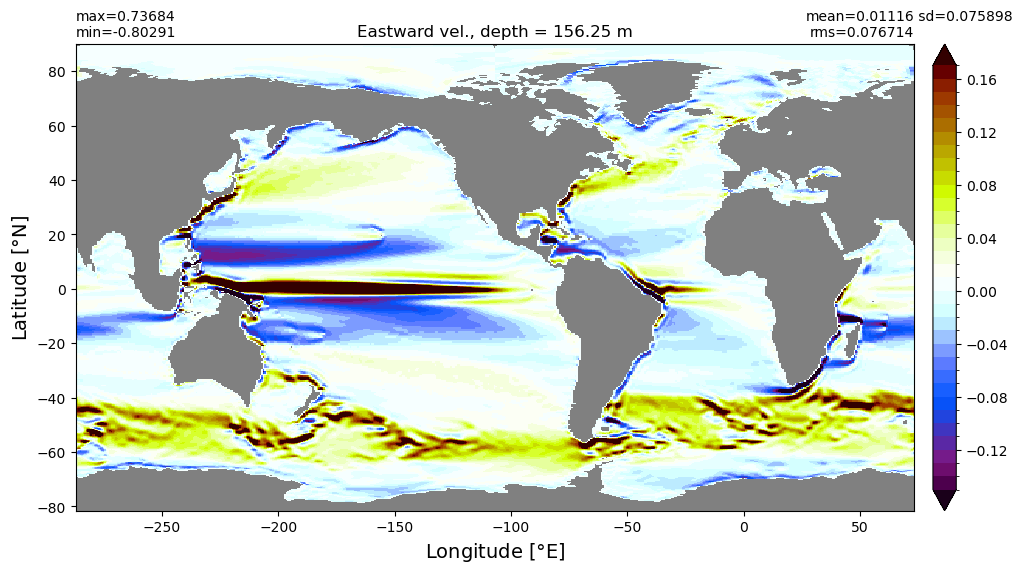

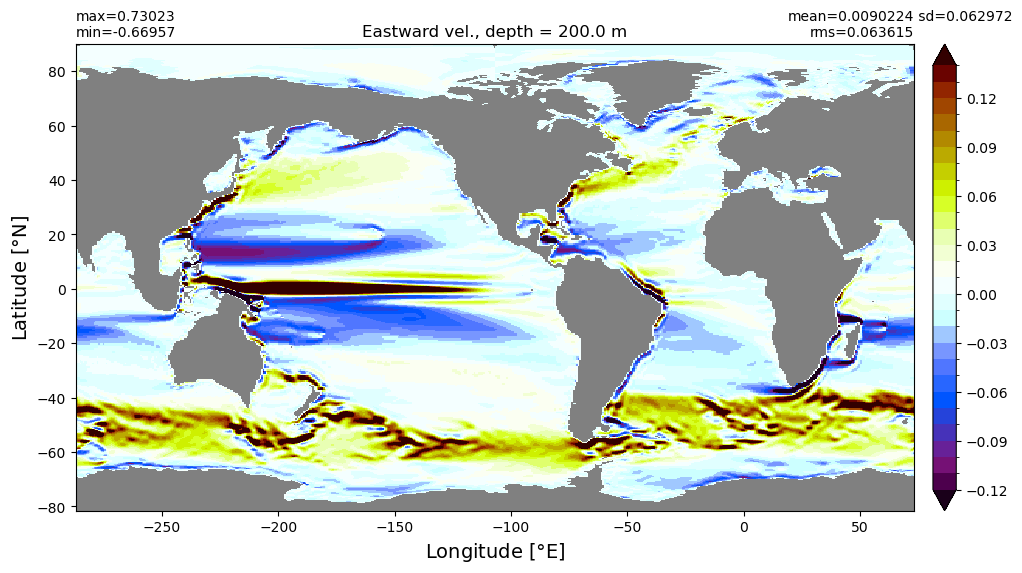

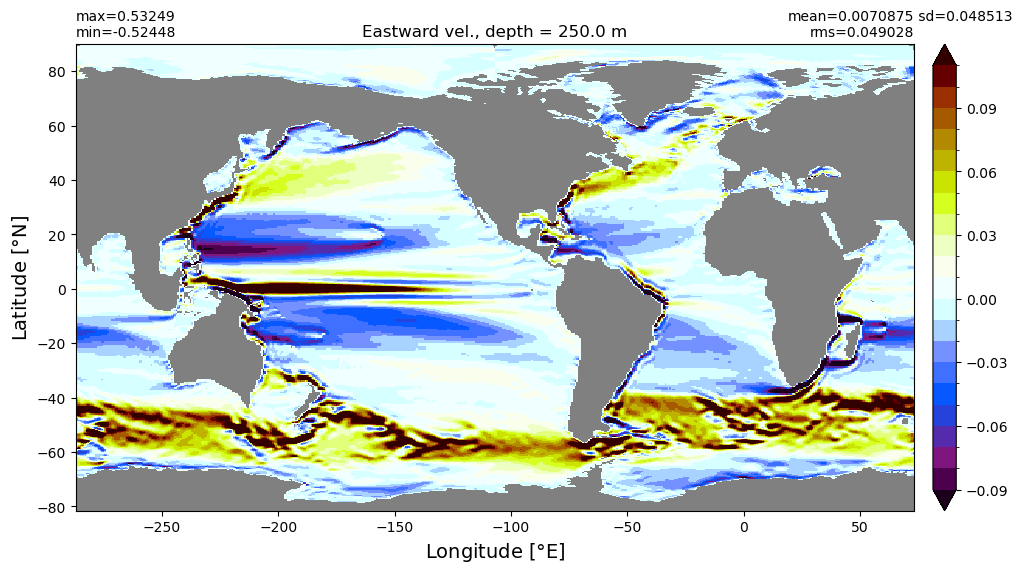

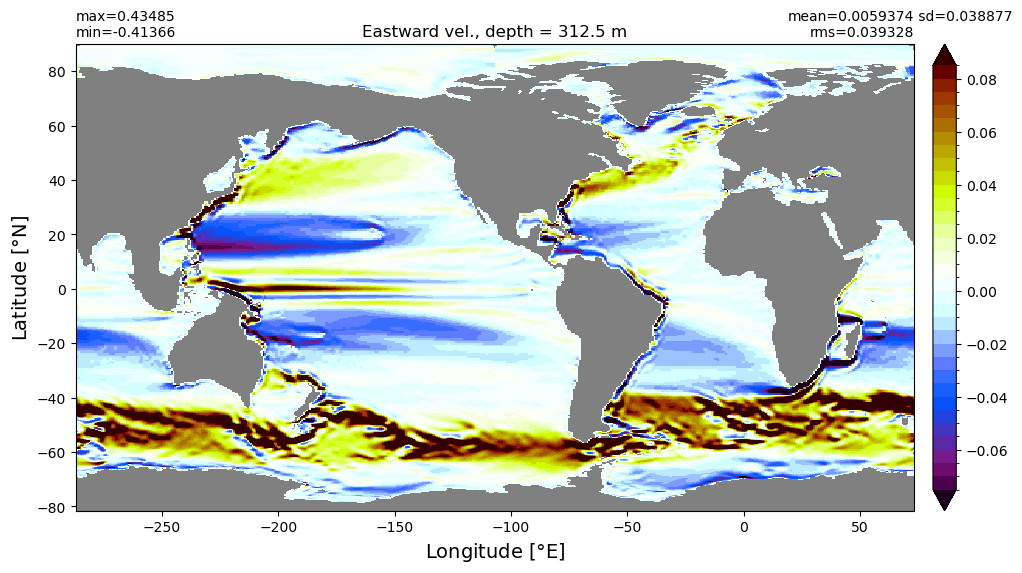

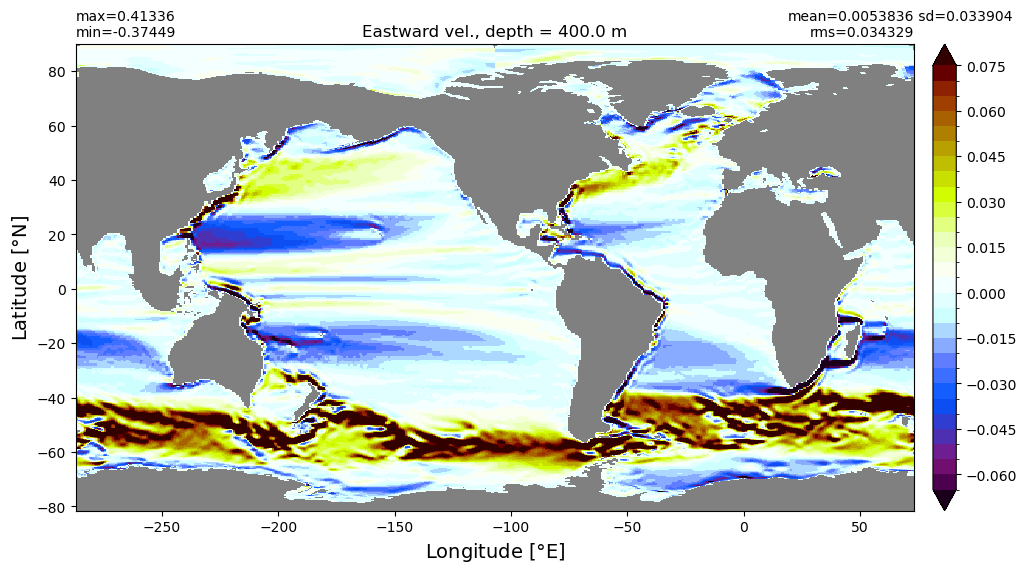

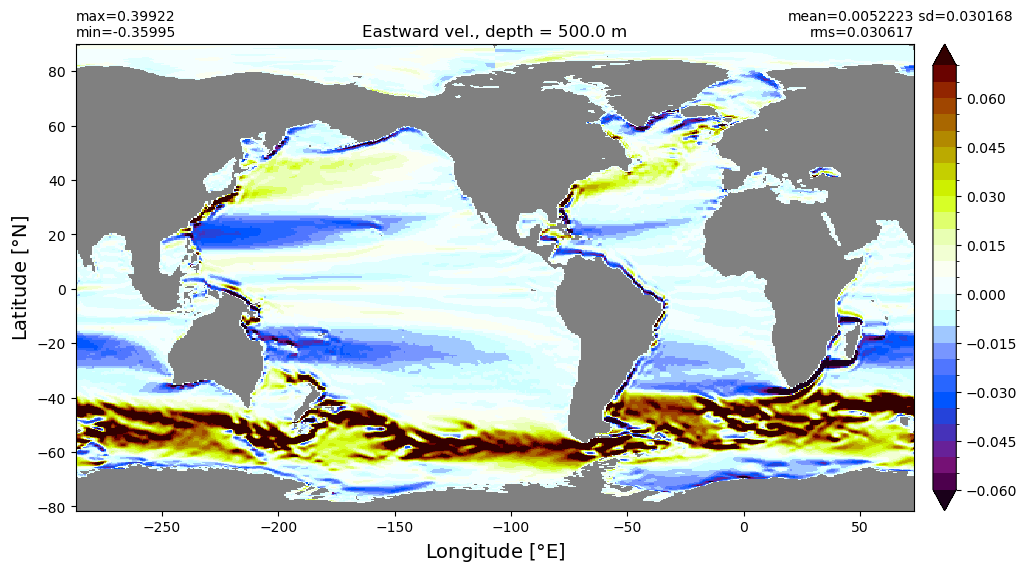

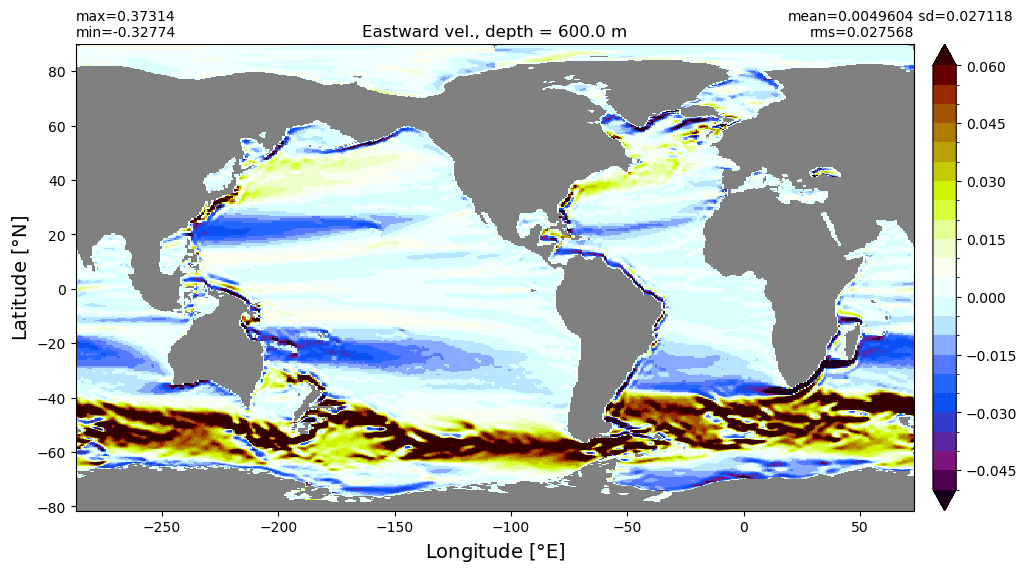

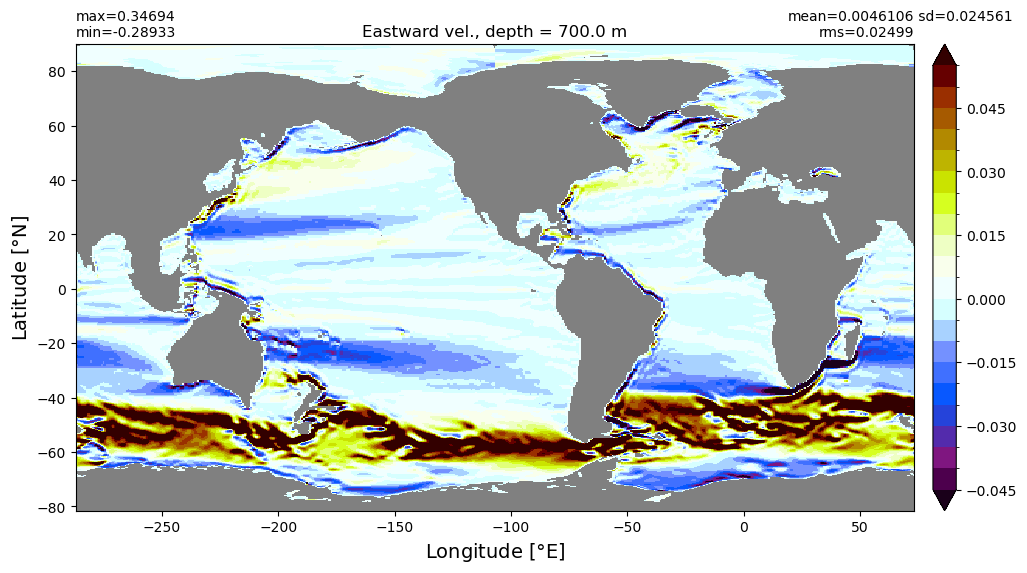

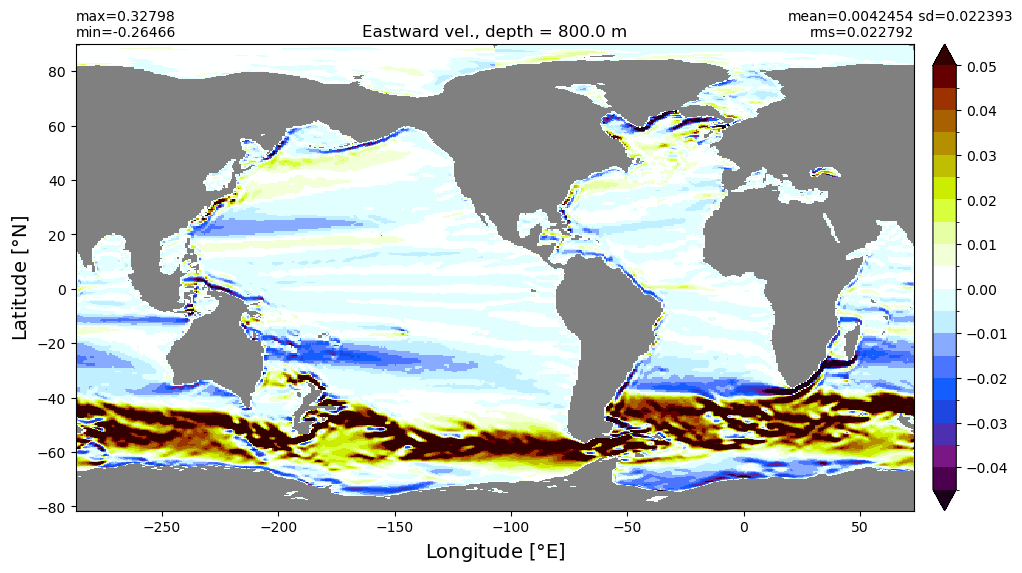

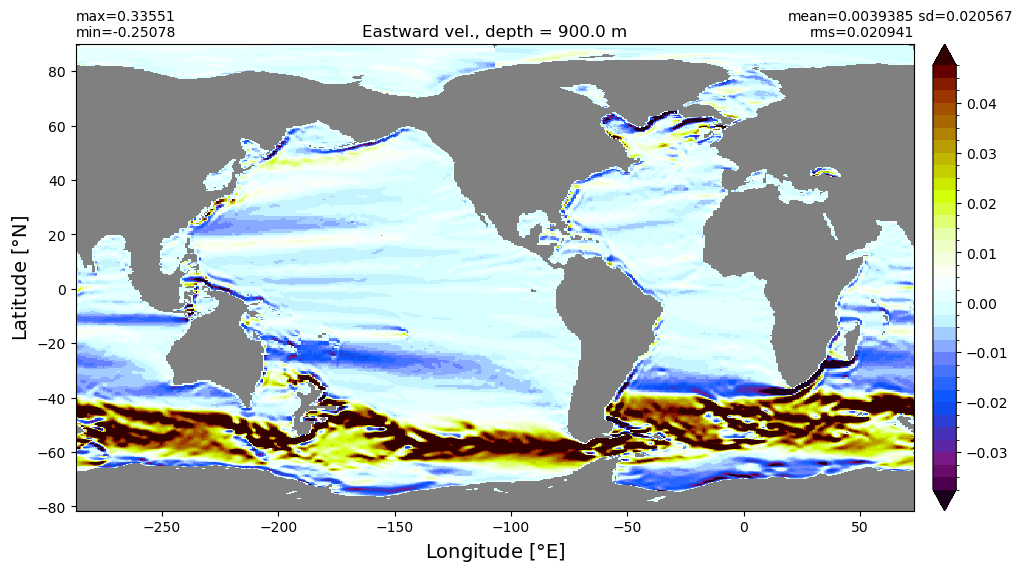

In [11]:
%matplotlib inline
# loop over depths 
km = uo.shape[0]
for k in range(km):
  # only shallower than 1000.0 m - this can be changed
  if ds_ann['z_l'][k].values < 1000.0:
    xyplot(uo[k,:],grd.geolon_u, grd.geolat_u, area=grd.areacello_cu,
          title = 'Eastward vel., depth = {} m'.format(str(ds_ann['z_l'][k].values)),
          extend='both',show= True)

### Meridional velocity

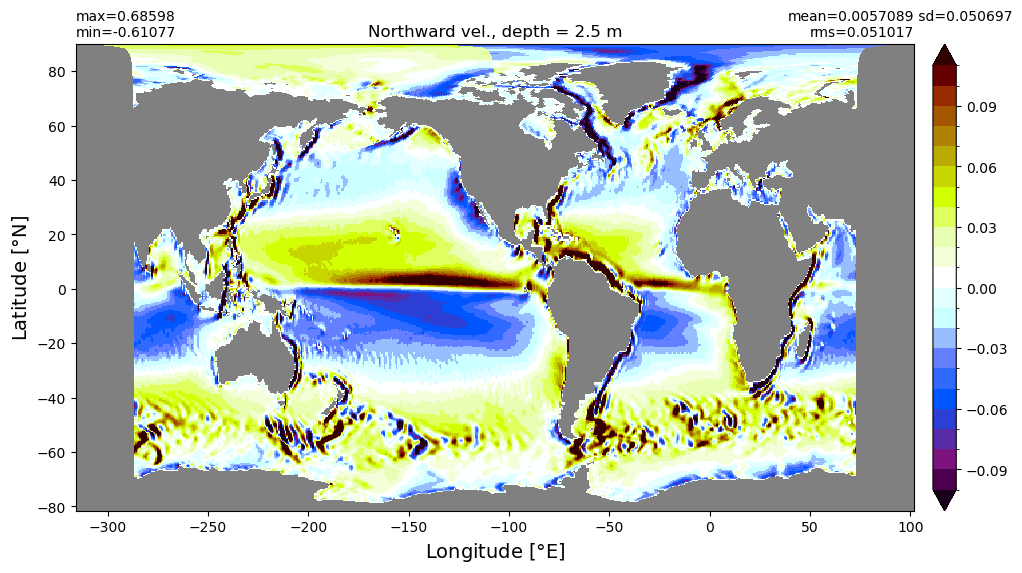

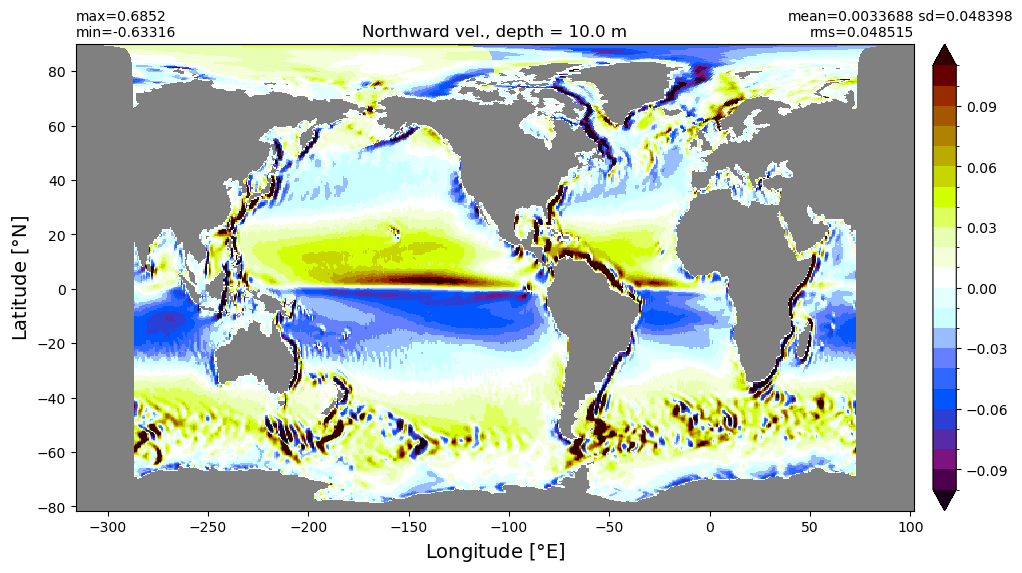

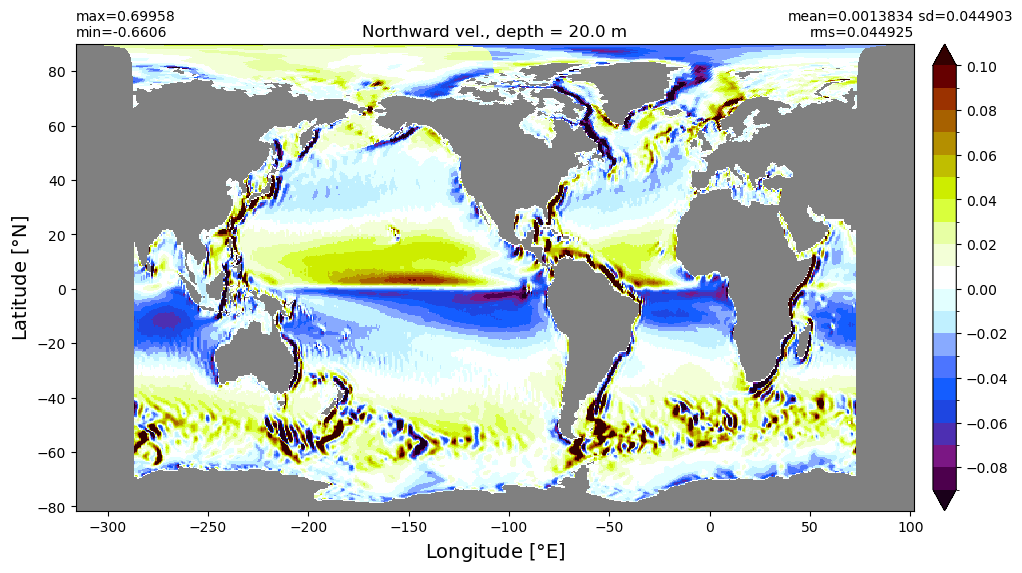

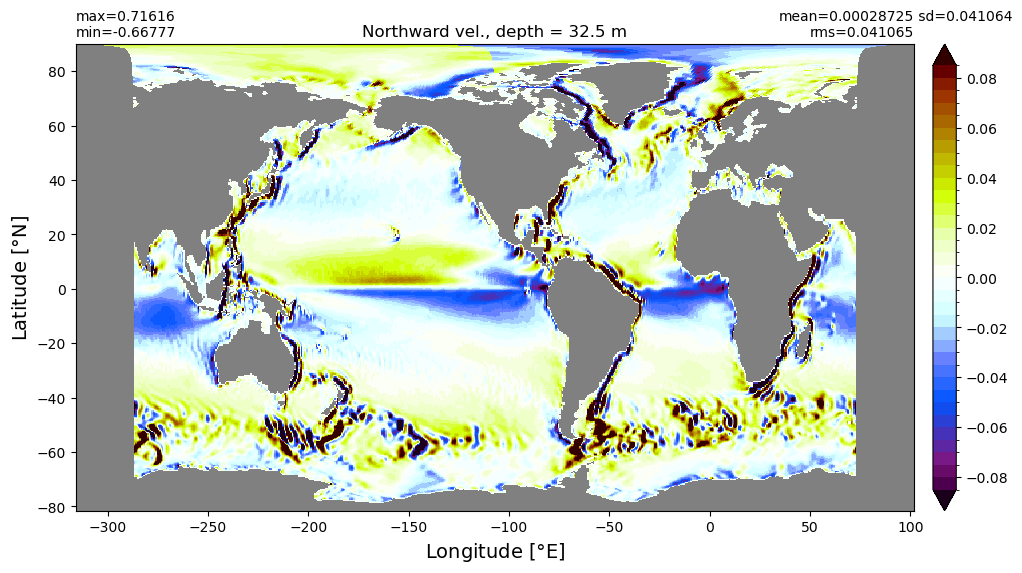

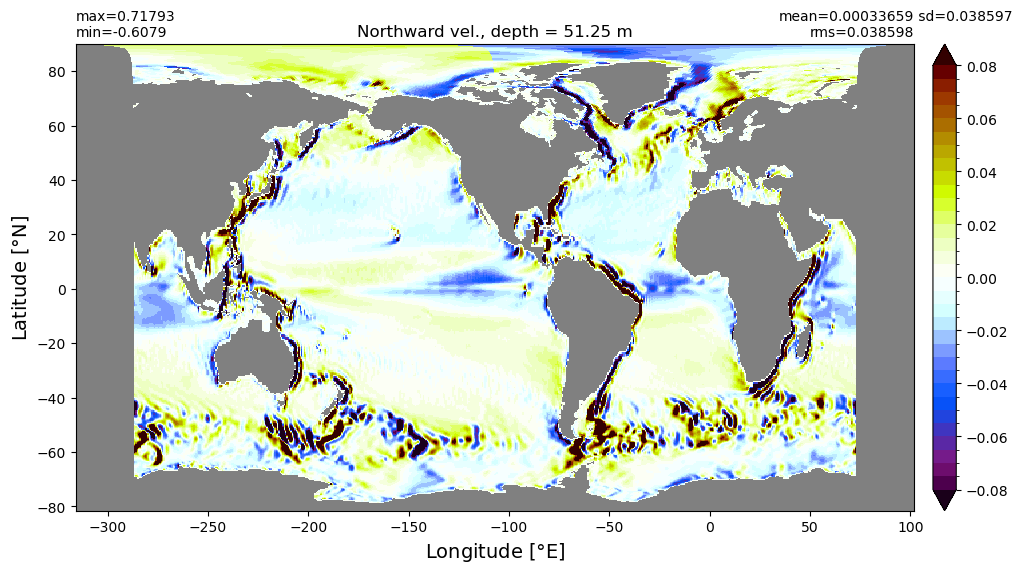

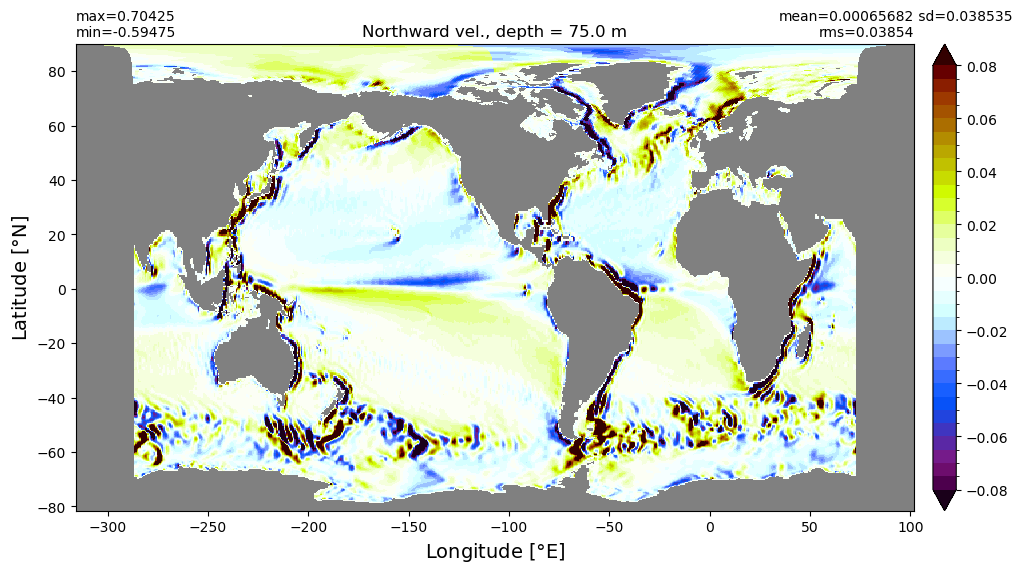

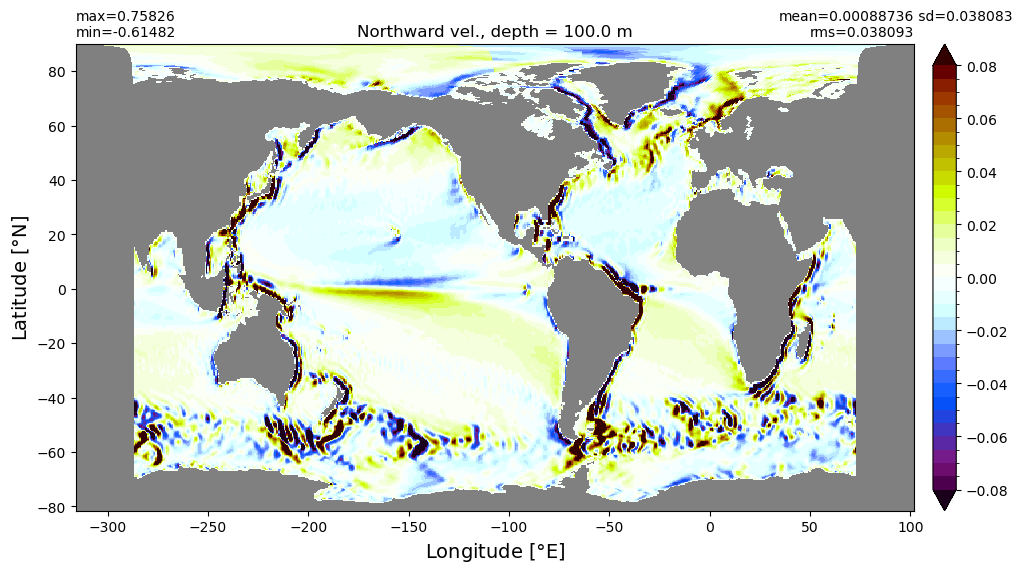

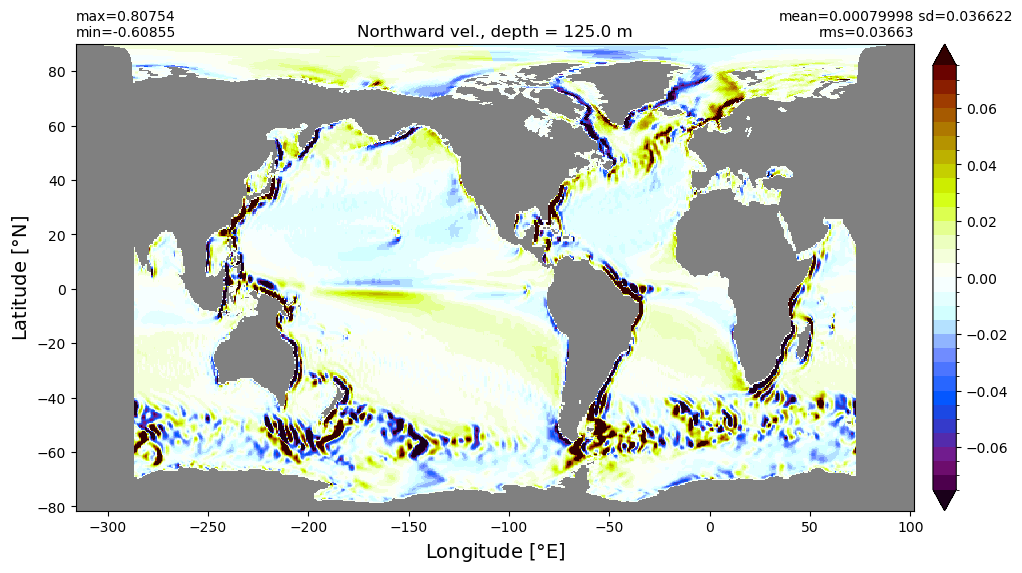

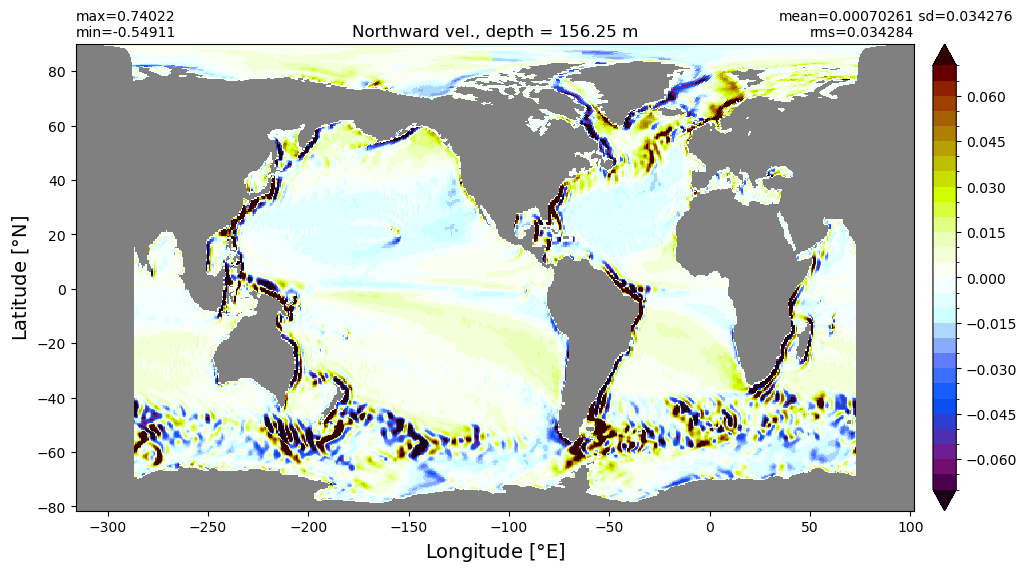

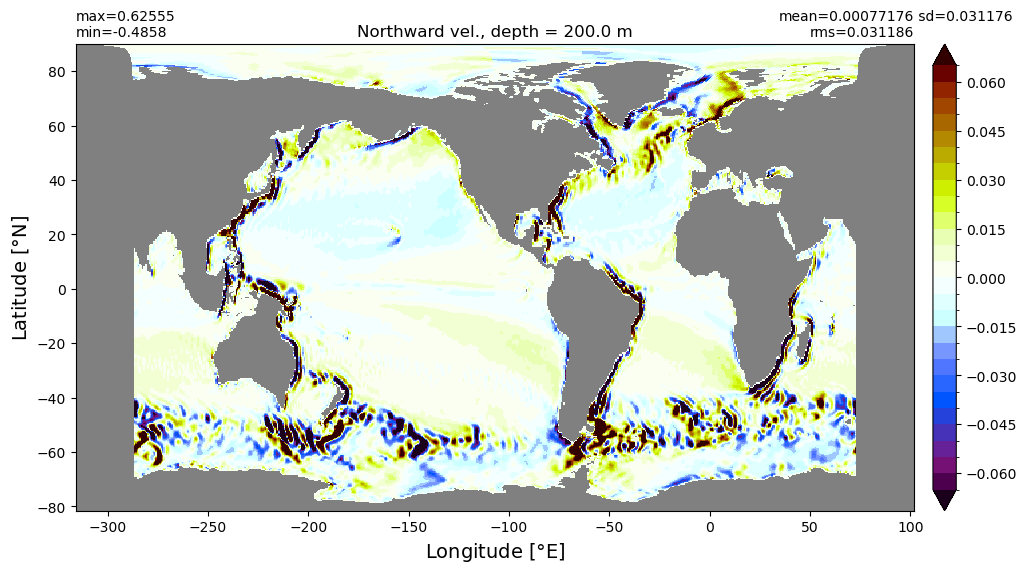

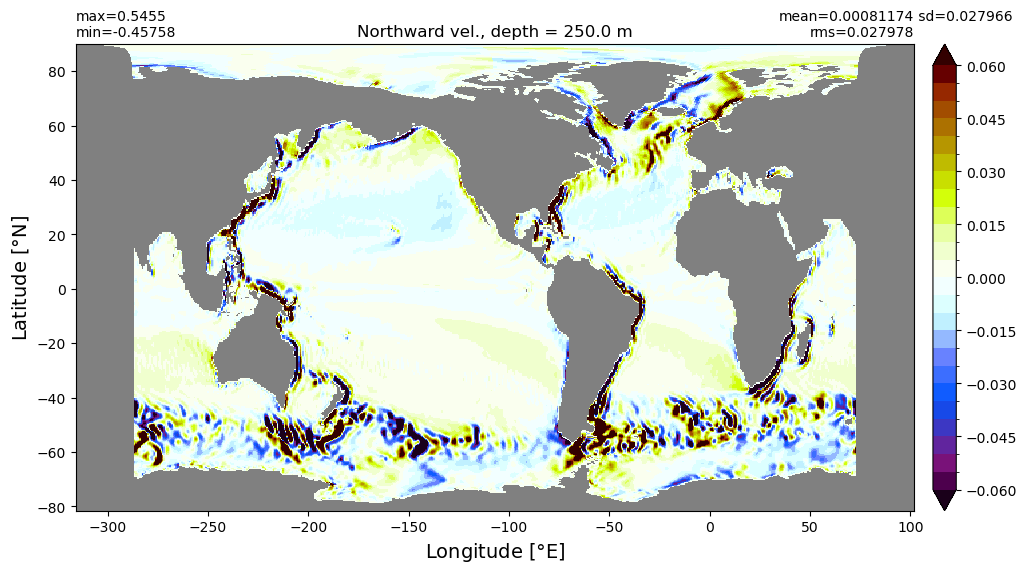

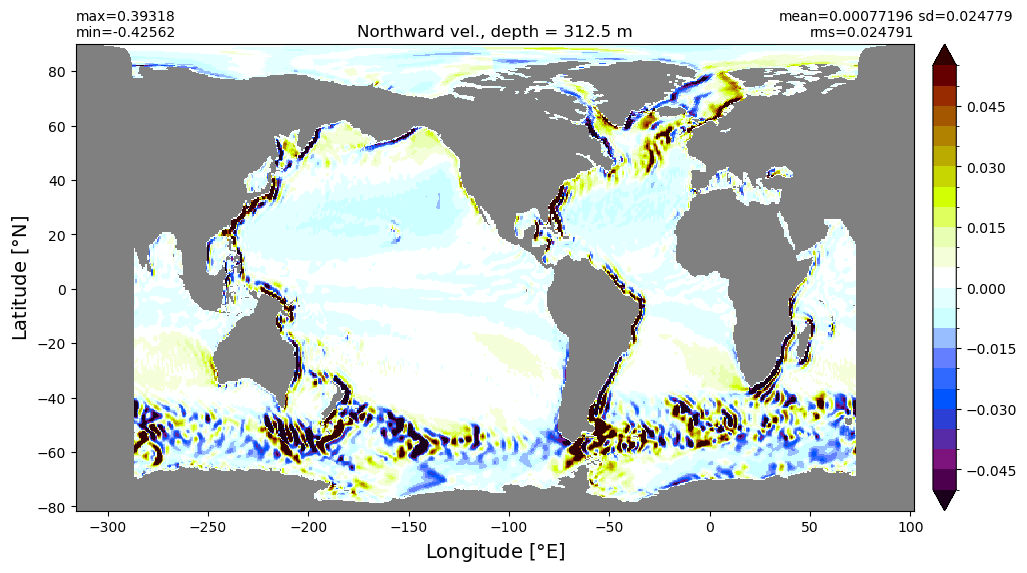

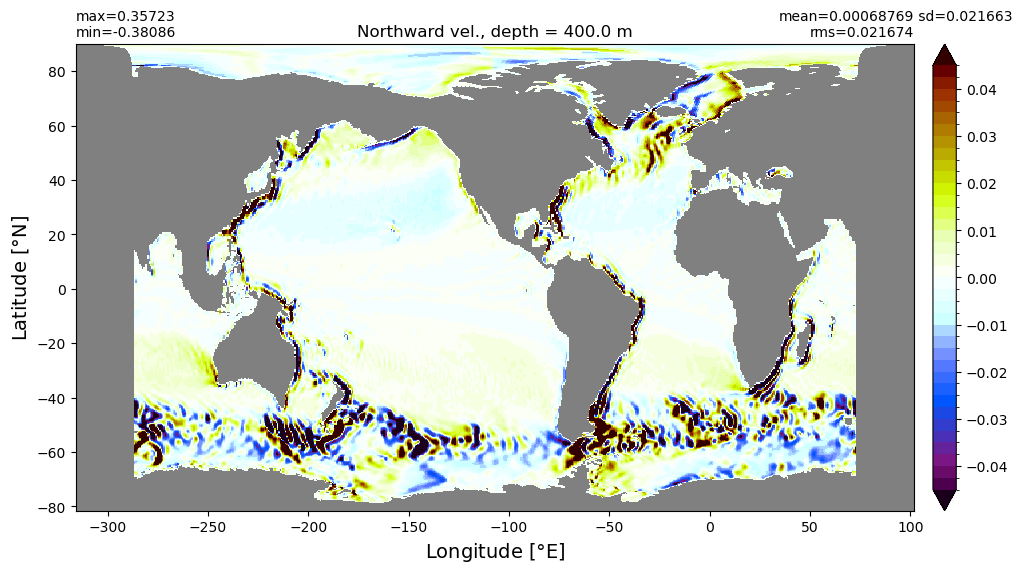

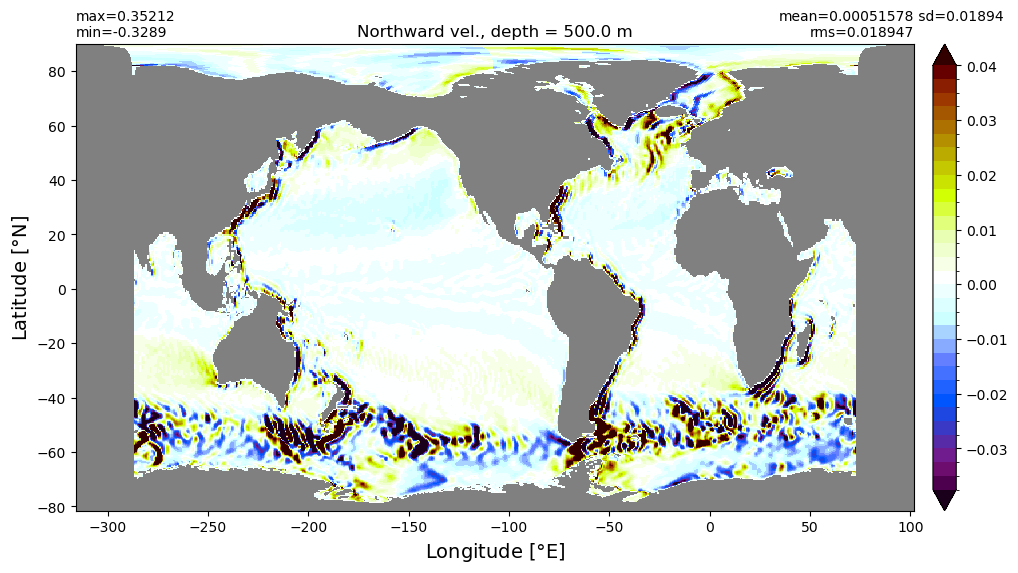

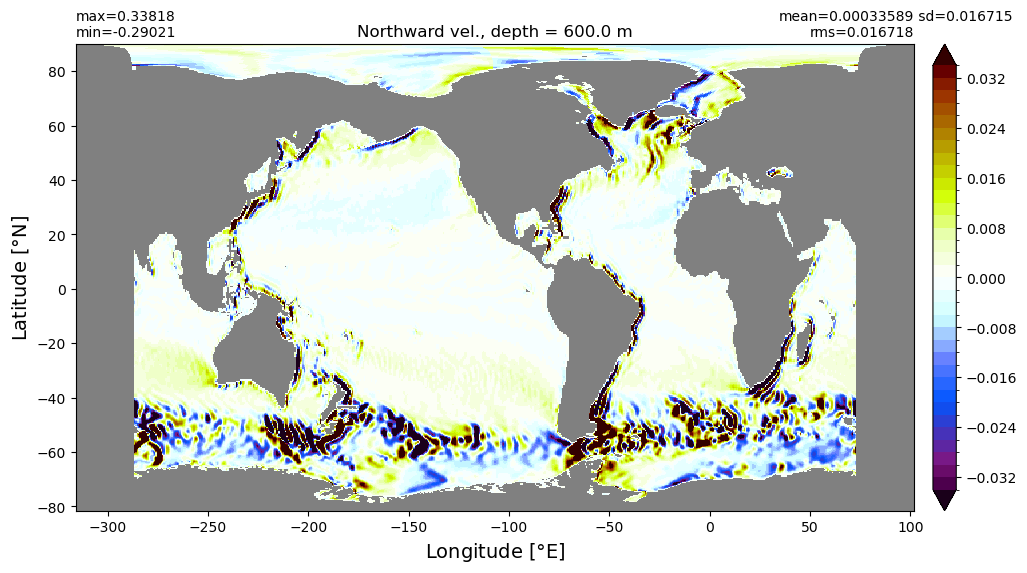

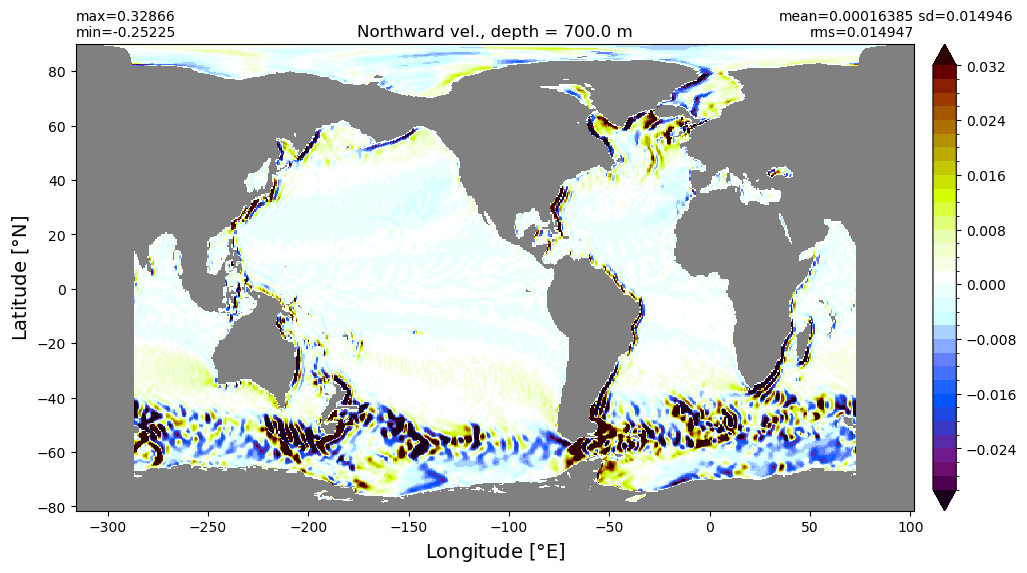

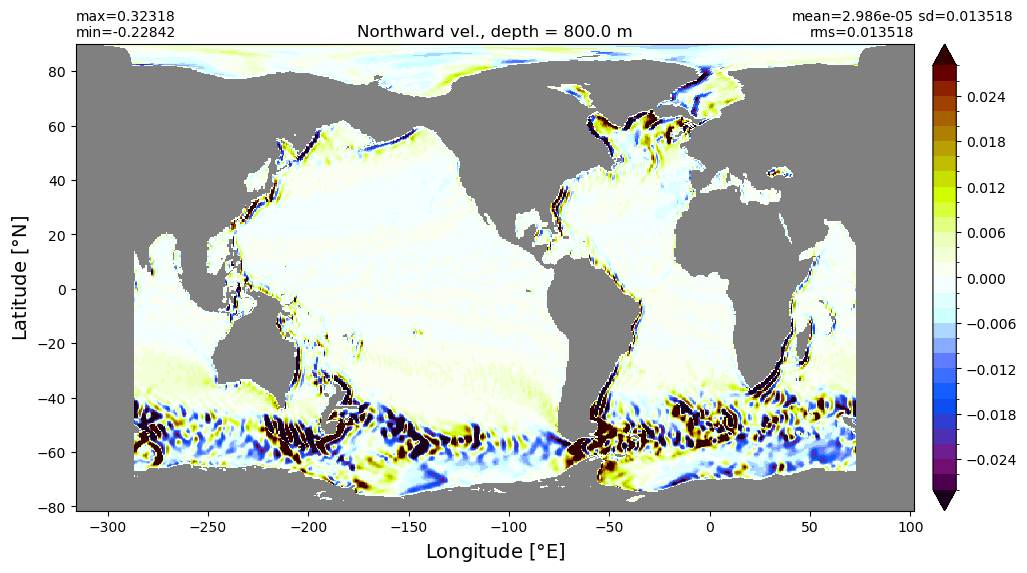

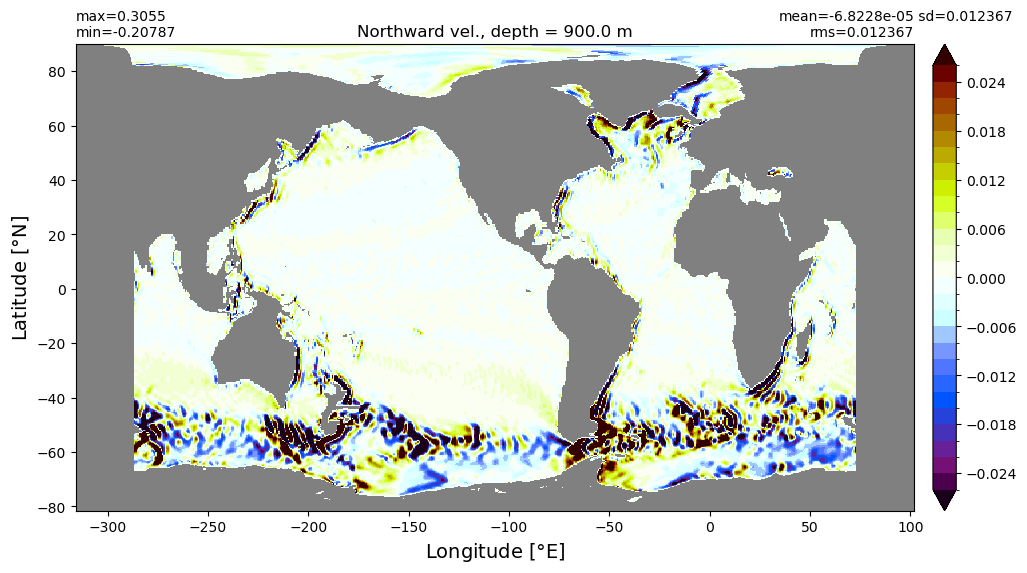

In [12]:
# loop over depths 
km = vo.shape[0]
for k in range(km):
  # only shallower than 1000.0 m - this can be changed
  if ds_ann['z_l'][k].values < 1000.0:
    xyplot(vo[k,:],grd.geolon_v, grd.geolat_v, area=grd.areacello_cv,
          title = 'Northward vel., depth = {} m'.format(str(ds_ann['z_l'][k].values)),
          extend='both',show= True)